## Importações

In [4]:
import pandas as pd
from math import floor
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from scipy.stats import norm
from sklearn.metrics import accuracy_score,classification_report, f1_score, confusion_matrix,recall_score,precision_score

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold,train_test_split,cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import f_classif, f_oneway, chi2,mutual_info_classif 
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier

## Funções Comuns

In [5]:
def funcPlotMatriz(y_test, classificar):
    matriz_de_confusao = confusion_matrix(y_test, classificar)
    sns.heatmap(matriz_de_confusao, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
    plt.show()


def funcMetricas(df_metricas,modelo_Versao, df,quant_columns,Hyper_Parametros,y_test, classificar):
    metricas = [
        modelo_Versao,
        df,
        quant_columns,
        Hyper_Parametros,
        accuracy_score(y_test, classificar), 
        round(recall_score(y_test, classificar, pos_label=0,average='macro'),2),
        round(precision_score(y_test, classificar, pos_label=0,average='macro'),2),
        round(f1_score(y_test, classificar, pos_label=0,average='macro'),2)
        ]
    
    nova_linha_df = pd.DataFrame([metricas], columns=df_metricas.columns)

    df_metricas = pd.concat([df_metricas, nova_linha_df], ignore_index=True)
    
    return df_metricas


## Extraindo a Base

In [6]:
df_original = pd.read_excel('..\dados\df_original.xlsx')

df = df_original.copy()

display(df)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.620000,64.000000,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,21,1.520000,56.000000,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.800000,77.000000,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.800000,87.000000,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.780000,89.800000,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20,1.710730,131.408528,yes,yes,3,3,Sometimes,no,2,no,2,1,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21,1.748584,133.742943,yes,yes,3,3,Sometimes,no,2,no,1,1,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22,1.752206,133.689352,yes,yes,3,3,Sometimes,no,2,no,1,1,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24,1.739450,133.346641,yes,yes,3,3,Sometimes,no,3,no,1,1,Sometimes,Public_Transportation,Obesity_Type_III


### Dividindo o Dataframe em Valor Explicativo e Resposta

In [7]:
df_x ,df_y= df.iloc[:, :-1],df.iloc[:, -1]

df_y = pd.DataFrame(df_y)
display(df_x)
display(df_y)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Female,21,1.620000,64.000000,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation
1,Female,21,1.520000,56.000000,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation
2,Male,23,1.800000,77.000000,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation
3,Male,27,1.800000,87.000000,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking
4,Male,22,1.780000,89.800000,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20,1.710730,131.408528,yes,yes,3,3,Sometimes,no,2,no,2,1,Sometimes,Public_Transportation
2107,Female,21,1.748584,133.742943,yes,yes,3,3,Sometimes,no,2,no,1,1,Sometimes,Public_Transportation
2108,Female,22,1.752206,133.689352,yes,yes,3,3,Sometimes,no,2,no,1,1,Sometimes,Public_Transportation
2109,Female,24,1.739450,133.346641,yes,yes,3,3,Sometimes,no,3,no,1,1,Sometimes,Public_Transportation


,NObeyesdad
0,Normal_Weight
1,Normal_Weight
2,Normal_Weight
3,Overweight_Level_I
4,Overweight_Level_II
...,...
2106,Obesity_Type_III
2107,Obesity_Type_III
2108,Obesity_Type_III
2109,Obesity_Type_III


### Transformando os Dados Qualitativos em Quantitativos

In [8]:
label_encolder = LabelEncoder()

preprocessador = ColumnTransformer(
    transformers=[
        ('categoria', OrdinalEncoder(), make_column_selector(dtype_include=['object','bool']))
    ],
    remainder='passthrough',  # Mantém as outras colunas inalteradas
    verbose_feature_names_out=False,  # Mantém os nomes originais das colunas
    
)

# Ajustar e transformar o DataFrame usando o preprocessador
df_x_encoded = preprocessador.fit_transform(df_x)

df_y_encoded = label_encolder.fit_transform(df_y)

# Se necessário, converter o resultado de volta para um DataFrame, mantendo os nomes das colunas
df_x_encoded = pd.DataFrame(df_x_encoded, columns=preprocessador.get_feature_names_out())
# Matém a ordem do df original
df_x_encoded = df_x_encoded[df_x.columns]

df_y_encoded = pd.DataFrame(df_y_encoded, columns=df_y.columns)

# df_x_encoded=df_x_encoded[df_x.columns]

df_encoded = df_x_encoded.copy()
df_encoded['NObeyesdad']=df_y_encoded
df_encoded

# df_x_encoded = df_x_encoded.apply(lambda col: col.astype(float) if col.dtype == 'int' else col)
# df_y_encoded = df_y_encoded.apply(lambda col: col.astype(float) if col.dtype == 'int' else col)

display(df_x_encoded)
display(df_y_encoded)

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,0.0,21.0,1.620000,64.000000,1.0,0.0,2.0,3.0,2.0,0.0,2.0,0.0,0.0,1.0,3.0,3.0
1,0.0,21.0,1.520000,56.000000,1.0,0.0,3.0,3.0,2.0,1.0,3.0,1.0,3.0,0.0,2.0,3.0
2,1.0,23.0,1.800000,77.000000,1.0,0.0,2.0,3.0,2.0,0.0,2.0,0.0,2.0,1.0,1.0,3.0
3,1.0,27.0,1.800000,87.000000,0.0,0.0,3.0,3.0,2.0,0.0,2.0,0.0,2.0,0.0,1.0,4.0
4,1.0,22.0,1.780000,89.800000,0.0,0.0,2.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0.0,20.0,1.710730,131.408528,1.0,1.0,3.0,3.0,2.0,0.0,2.0,0.0,2.0,1.0,2.0,3.0
2107,0.0,21.0,1.748584,133.742943,1.0,1.0,3.0,3.0,2.0,0.0,2.0,0.0,1.0,1.0,2.0,3.0
2108,0.0,22.0,1.752206,133.689352,1.0,1.0,3.0,3.0,2.0,0.0,2.0,0.0,1.0,1.0,2.0,3.0
2109,0.0,24.0,1.739450,133.346641,1.0,1.0,3.0,3.0,2.0,0.0,3.0,0.0,1.0,1.0,2.0,3.0


,NObeyesdad
0,1
1,1
2,1
3,5
4,6
...,...
2106,4
2107,4
2108,4
2109,4


#### Dividindo os DataFrames de Teste e Treino

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_x_encoded, df_y_encoded, test_size=0.25,random_state=42,shuffle=True)
X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)
# Salva o array na memoria para guardar a ordem das colunas
# X_train = np.ascontiguousarray(X_train)
# X_test = np.ascontiguousarray(X_test)

## Modelo KNN

## Teste Simples

In [10]:
classificador_KNN = KNeighborsClassifier() 

scores = cross_validate(classificador_KNN, X_train, y_train, cv=5, scoring=['accuracy','precision_macro','recall_macro','f1_macro'])
chaves = ['test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']

scores_avg = [scores[chave].mean() for chave in chaves] 
print(scores)
print(scores_avg)


c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site

{'fit_time': array([0.03842854, 0.00469398, 0.00451207, 0.00400949, 0.00500321]), 'score_time': array([1.42902708, 0.49742103, 0.60160446, 0.72476888, 0.77130771]), 'test_accuracy': array([0.86750789, 0.86119874, 0.85488959, 0.84177215, 0.83227848]), 'test_precision_macro': array([0.86373176, 0.86072411, 0.85794376, 0.83823817, 0.829307  ]), 'test_recall_macro': array([0.86237143, 0.85669548, 0.8512406 , 0.83591268, 0.83021293]), 'test_f1_macro': array([0.8580319 , 0.85335125, 0.8489862 , 0.83053214, 0.82670686])}
[0.8515293694844868, 0.8499889607218021, 0.8472866215696879, 0.8435216700236857]


In [11]:
display(X_test)

array([[ 0.      , 20.      ,  1.755978, ...,  2.      ,  3.      ,
         3.      ],
       [ 0.      , 26.      ,  1.62495 , ...,  0.      ,  2.      ,
         3.      ],
       [ 1.      , 18.      ,  1.85    , ...,  0.      ,  2.      ,
         0.      ],
       ...,
       [ 0.      , 23.      ,  1.75    , ...,  0.      ,  2.      ,
         3.      ],
       [ 0.      , 39.      ,  1.65    , ...,  0.      ,  2.      ,
         3.      ],
       [ 1.      , 30.      ,  1.784049, ...,  0.      ,  2.      ,
         0.      ]])

In [12]:
classificador_KNN.fit(X_train, y_train)
classificar = classificador_KNN.predict(X_test)
print(classification_report(y_test,classificar))

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

           0       0.78      0.96      0.86        68
           1       0.78      0.51      0.62        78
           2       0.90      0.95      0.92        94
           3       0.97      0.97      0.97        75
           4       0.98      1.00      0.99        79
           5       0.81      0.89      0.85        71
           6       0.87      0.84      0.85        63

    accuracy                           0.88       528
   macro avg       0.87      0.87      0.87       528
weighted avg       0.87      0.88      0.87       528



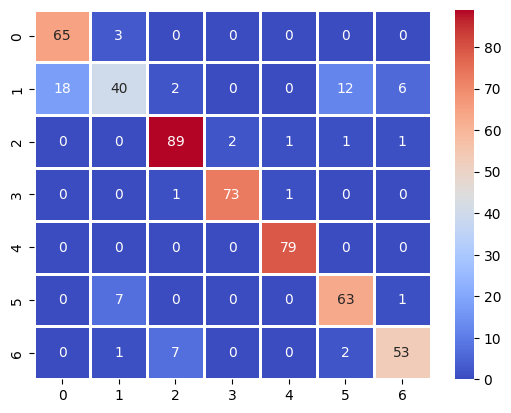

In [13]:
funcPlotMatriz(y_test, classificar)

## Entendendo o Resultado do Modelo

O modelo KNN funciona assumindo que pontos de dados próximos no espaço de características tendem a pertencer à mesma classe. Esses pontos próximos são chamados de vizinhos, e há diversas maneiras de calcular as distâncias entre eles, podendo escolher entre várias métricas. Além disso, é possível ajustar a influência dos vizinhos, atribuindo maior peso aos mais próximos.

Segue uma imagem para ilustrar o ponto alvo e seus vizinhos: 


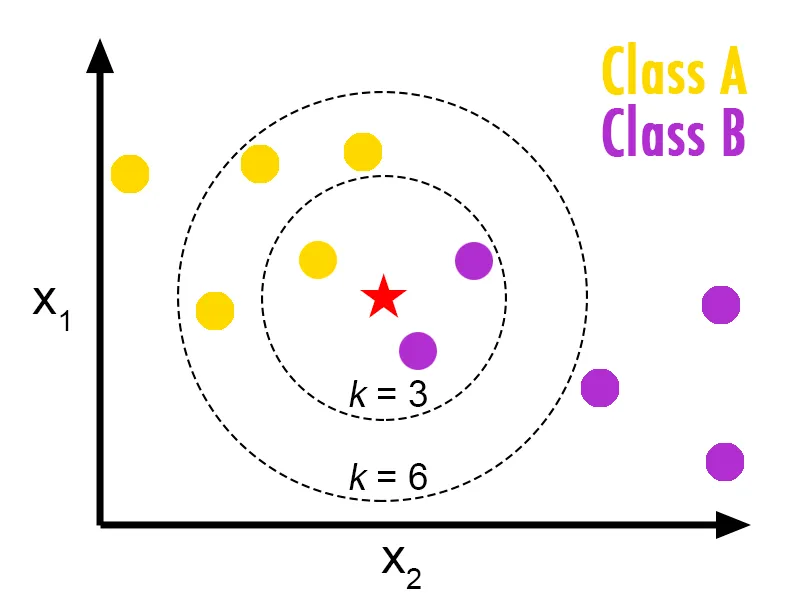


Fatores como a distribuição dos dados, correlações entre as características e a dimensionalidade do espaço influenciam o desempenho do KNN. A dimensionalidade, em particular, tem grande importância devido à maldição da dimensionalidade, que será explicada no próximo texto. No entanto, o KNN permite ajustar esses fatores através dos hiperparâmetros do modelo.


Logo, considerando que o resultado atual do modelo já está bom, podemos tentar aprimorá-lo ainda mais testando diferentes variações e ajustando os hiperparâmetros para melhor adequação ao nosso caso de uso.

### Maldição da Dimensionalidade

In [14]:
len(df_x.columns)

16

Outro fator que pode estar prejudicando o desempenho do modelo é a alta quantidade de dimensões (colunas). Esse problema é denominado "Maldição da Dimensionalidade", termo introduzido pelo matemático R. Bellman, que se refere ao problema causado pelo aumento exponencial no volume associado à adição de dimensões extras a um espaço matemático.

Por exemplo:

Se dividirmos uma região do espaço em células regulares, o número de células cresce exponencialmente com a dimensão do espaço. Vamos denominar a dimensão como 
𝐷 e as células como 𝑁.


Se tivermos uma dimensão 𝐷1, com um número qualquer de células como 𝑁:


Ao aumentarmos uma dimensão, passando a ter 𝐷2, precisaremos ter o número de células como 𝑁^2.


Assim como 𝐷3 passaria a ter 𝑁^3, e assim por diante.


O que quero dizer é que, para um número qualquer de dimensões, é necessário ter a quantidade certa de amostras de dados. Isso nos leva a pensar que essa quantidade de amostras pode ser insuficiente ou excedente para essa quantidade de dimensões.

Algumas imagens que ilustram a explicação:

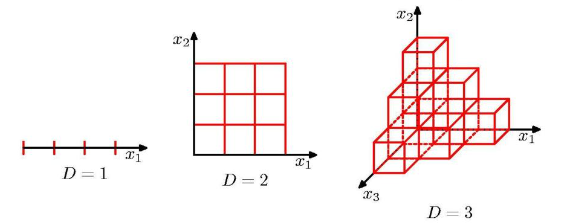

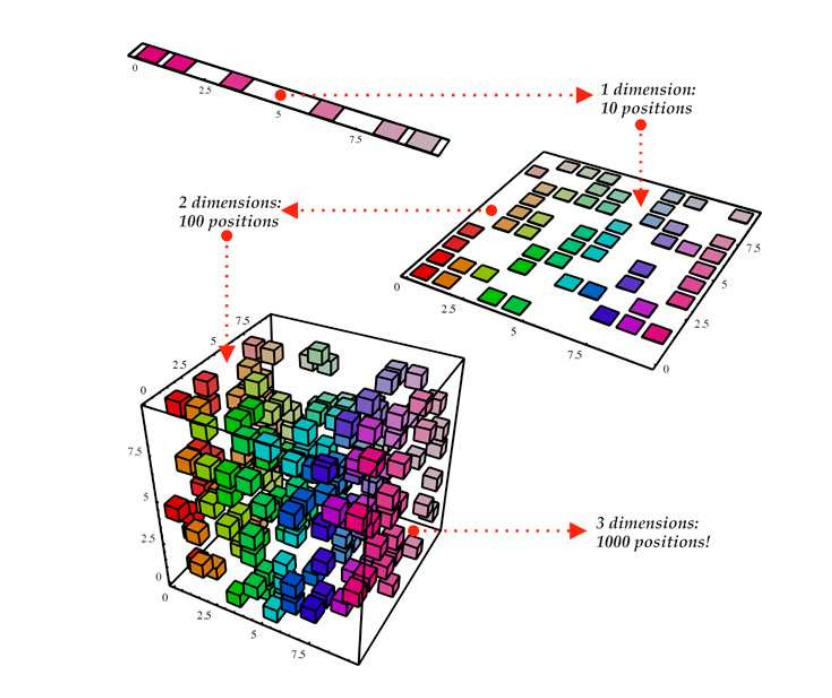

Além de tudo isso, o modelo KNN não trabalha muito bem com bases de dados com muitas dimensões, pois em altas dimensões, as distâncias entre os pontos tendem a se tornar uniformes, reduzindo a capacidade do KNN de diferenciar bem vizinhos próximos e distantes.

E com muitas dimensões, é muito provável que muitas características irrelevantes tenham sido incluídas, sem adicionar valor informativo, diminuindo a influência das características relevantes.

### Distribuição das Classes Resposta

Iremos verificar a distribuição das classes, por conta do KNN no geral se comportar mal com classes desbalanceadas. 
O algoritmo pode favorecer as classes majoritárias, resultando em predições enviesadas.

In [15]:
display(df_y_encoded.value_counts())
display(y_train.value_counts())
display(y_test.value_counts())

NObeyesdad
2             351
4             324
3             297
5             290
6             290
1             287
0             272
dtype: int64

NObeyesdad
2             257
4             245
6             227
3             222
5             219
1             209
0             204
dtype: int64

NObeyesdad
2             94
4             79
1             78
3             75
5             71
0             68
6             63
dtype: int64

As classes resposta estão bem balanceadas, sem mostrar grandes disparidades

## Teste do Modelo Embasado Nos Resultados Anteriores e em Obter o Melhor Desempenho Possível do Modelo

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

### Importando e Tratando Todas as Bases Alterádas em Análise Axploratória

In [17]:
lista_df = [] # Lista para armazenar os dfs

In [18]:
lista_df.append(df)

df_capping = pd.read_excel('..\dados\df_capping.xlsx')
display(df_capping.head(2))
lista_df.append(df_capping)

df_iqr = pd.read_excel('..\dados\df_iqr.xlsx')
display(df_iqr.head(2))
lista_df.append(df_iqr)

df_log = pd.read_excel('..\dados\df_log.xlsx')
display(df_log.head(2))
lista_df.append(df_log)

df_raiz = pd.read_excel('..\dados\df_raiz.xlsx')
display(df_raiz.head(2))
lista_df.append(df_raiz)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,3.091042,1.62,64.0,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,3.091042,1.52,56.0,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,4.582576,1.62,64.0,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,4.582576,1.52,56.0,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight


In [19]:
df_capping.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [20]:
for k,v in enumerate(lista_df):
    ordem_colunas = lista_df[k].columns
    lista_df[k] = preprocessador.fit_transform(v)
    lista_df[k] = pd.DataFrame(lista_df[k], columns=preprocessador.get_feature_names_out())
    lista_df[k] = lista_df[k][ordem_colunas]


### PIPELINE

In [21]:
classificador_KNN.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Esta pipeline será utilizada para, organizar os passos de transformação de dados e para tentar aplicar o melhor modelo possivel nas condições do nosso caso. Além disso, ela também é muito util para replicar o processo em outros modelos. 

### Explicação da Pipeline

- "df_metricas" -> DataFrame que armazena o nome do modelo, o DataFrame utilizado, as métricas de teste e a melhor combinação de hiperparâmetros encontrada.
  
- "pipe" -> Variável que armazena todos os processos que compõem a pipeline.
    - `StandardScaler` -> Centraliza os dados em torno de zero, subtraindo a média de cada coluna e dividindo pelo desvio padrão, normalizando a dispersão dos dados.
    - `SelectKBest` -> Seleciona as features mais importantes da base de dados, auxiliando na redução de dimensionalidade. Utilizo esse método para reduzir o número de perguntas que serão feitas ao usuário, de 16 para, no máximo, 10.
    - `PCA` -> Reduz a dimensionalidade após o SelectKBest, preservando o máximo de variância nos dados.
    - `KNeighborsClassifier` -> Modelo de machine learning utilizado após a redução de dimensionalidade.

- "params_pipe" -> Lista de parâmetros que serão testados na pipeline.
    - `SelectKBest__k` e `pca__n_components` -> Definem o número de colunas a serem mantidas na redução dimensional.
    - `SelectKBest__score_func` -> Funções de avaliação usadas para selecionar as colunas mais relevantes.
    - `model__algorithm` -> Especifica o algoritmo a ser usado para computar os vizinhos mais próximos.
    - `model__metric` -> Especifica a métrica de distância usada para calcular a proximidade entre os pontos.
    - `model__weights` -> Determina a forma como os vizinhos influenciam a predição.
    - `model__n_neighbors` -> Define o número de vizinhos a serem considerados para realizar a predição.


- "valores_k" -> Define o número máximo de colunas a serem selecionadas (até 10) pelo SelectKBest.

- GridSearchCV -> Executa a pipeline com diferentes combinações de hiperparâmetros, realiza validação cruzada e encontra a combinação que otimiza a acurácia.

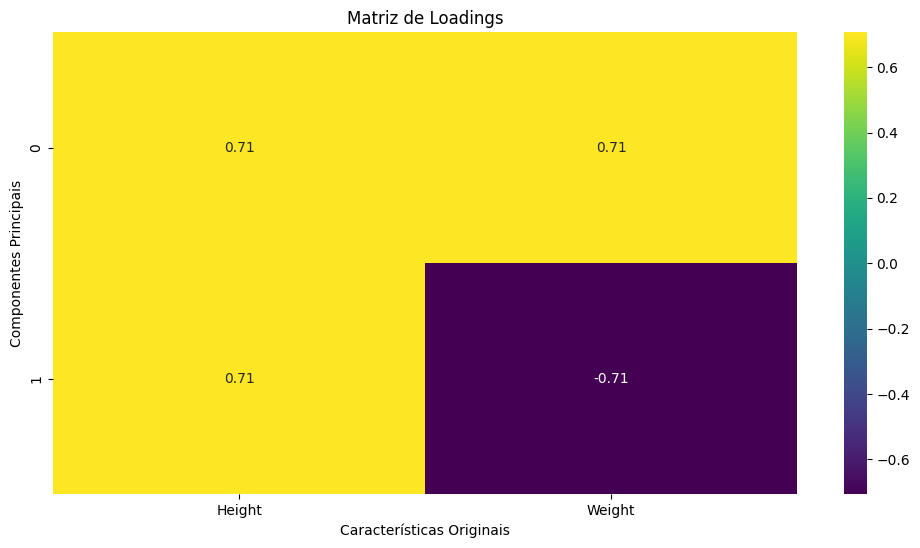

Melhores parametros:  {'SelectKBest__k': 2, 'SelectKBest__score_func': <function mutual_info_classif at 0x0000025D73D1A840>, 'model__algorithm': 'auto', 'model__metric': 'minkowski', 'model__n_neighbors': 2, 'model__weights': 'distance', 'pca__n_components': 2}
Melhor accuracy:  0.9494788962983668
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95        68
         1.0       0.93      0.88      0.91        78
         2.0       0.98      0.96      0.97        94
         3.0       0.95      0.96      0.95        75
         4.0       0.99      0.99      0.99        79
         5.0       0.93      0.93      0.93        71
         6.0       0.95      0.98      0.97        63

    accuracy                           0.95       528
   macro avg       0.95      0.95      0.95       528
weighted avg       0.95      0.95      0.95       528



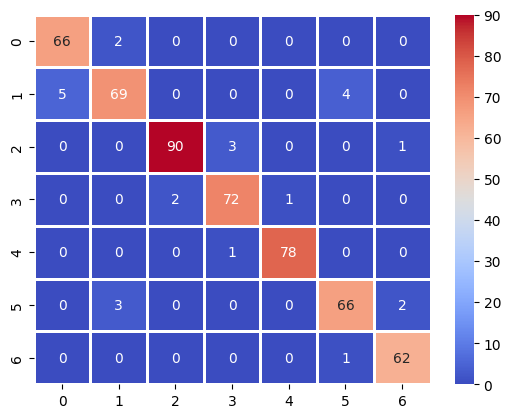

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


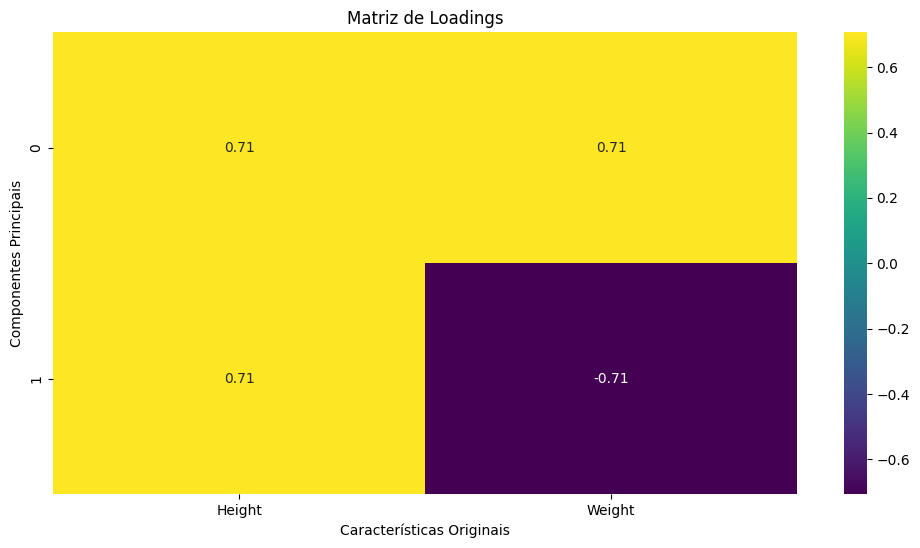

Melhores parametros:  {'SelectKBest__k': 2, 'SelectKBest__score_func': <function mutual_info_classif at 0x0000025D73D1A840>, 'model__algorithm': 'auto', 'model__metric': 'minkowski', 'model__n_neighbors': 2, 'model__weights': 'distance', 'pca__n_components': 2}
Melhor accuracy:  0.9494788962983668
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95        68
         1.0       0.93      0.88      0.91        78
         2.0       0.98      0.96      0.97        94
         3.0       0.95      0.96      0.95        75
         4.0       0.99      0.99      0.99        79
         5.0       0.93      0.93      0.93        71
         6.0       0.95      0.98      0.97        63

    accuracy                           0.95       528
   macro avg       0.95      0.95      0.95       528
weighted avg       0.95      0.95      0.95       528



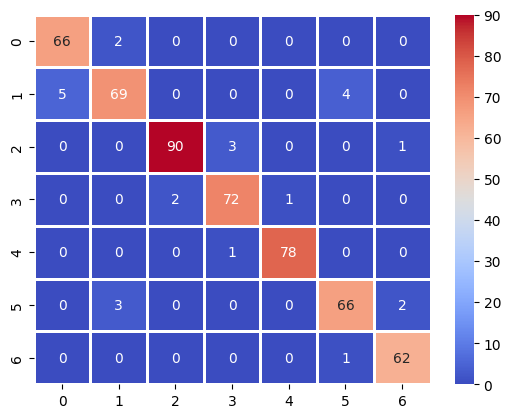

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


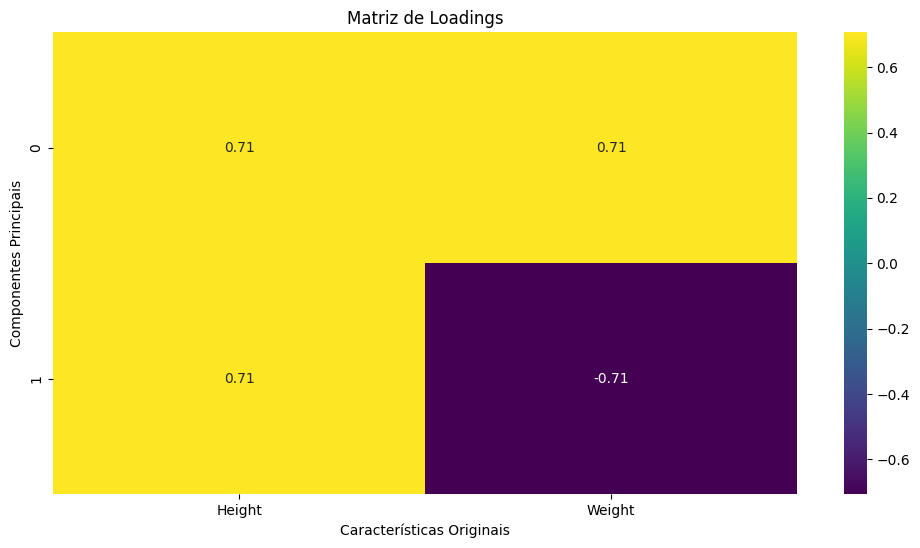

Melhores parametros:  {'SelectKBest__k': 2, 'SelectKBest__score_func': <function mutual_info_classif at 0x0000025D73D1A840>, 'model__algorithm': 'auto', 'model__metric': 'minkowski', 'model__n_neighbors': 5, 'model__weights': 'distance', 'pca__n_components': 2}
Melhor accuracy:  0.955867635189669
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97        85
         1.0       0.93      0.89      0.91        70
         2.0       0.95      1.00      0.97        70
         3.0       1.00      0.95      0.98        64
         4.0       1.00      1.00      1.00        79
         5.0       0.88      0.91      0.90        66
         6.0       0.95      0.93      0.94        57

    accuracy                           0.95       491
   macro avg       0.95      0.95      0.95       491
weighted avg       0.95      0.95      0.95       491



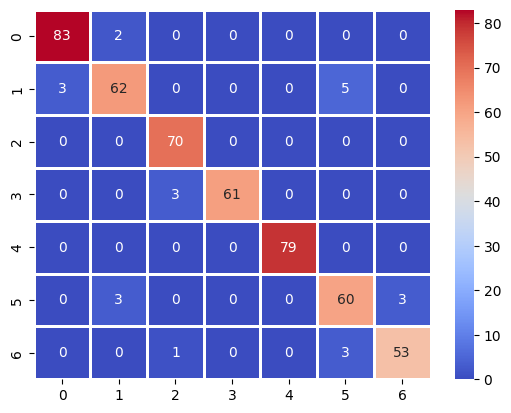

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


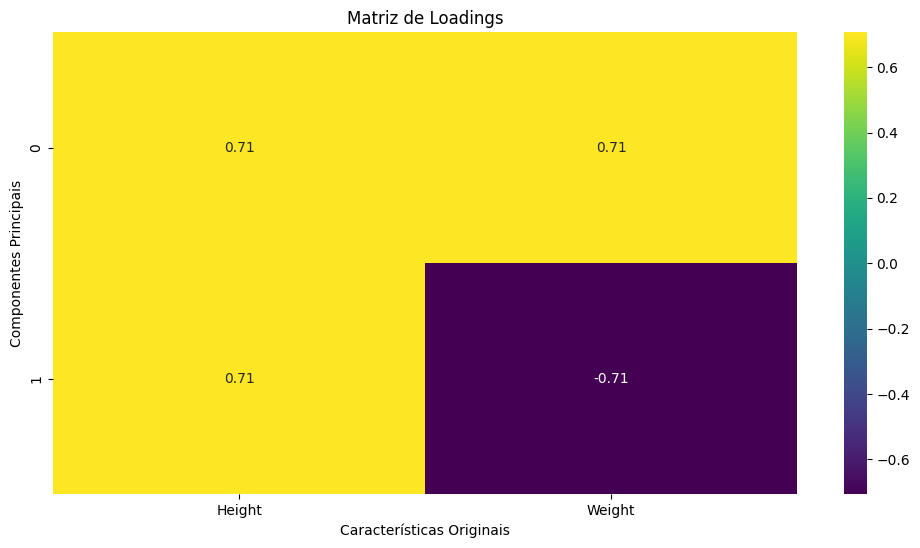

Melhores parametros:  {'SelectKBest__k': 2, 'SelectKBest__score_func': <function mutual_info_classif at 0x0000025D73D1A840>, 'model__algorithm': 'auto', 'model__metric': 'euclidean', 'model__n_neighbors': 2, 'model__weights': 'distance', 'pca__n_components': 2}
Melhor accuracy:  0.9494788962983668
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95        68
         1.0       0.93      0.88      0.91        78
         2.0       0.98      0.96      0.97        94
         3.0       0.95      0.96      0.95        75
         4.0       0.99      0.99      0.99        79
         5.0       0.93      0.93      0.93        71
         6.0       0.95      0.98      0.97        63

    accuracy                           0.95       528
   macro avg       0.95      0.95      0.95       528
weighted avg       0.95      0.95      0.95       528



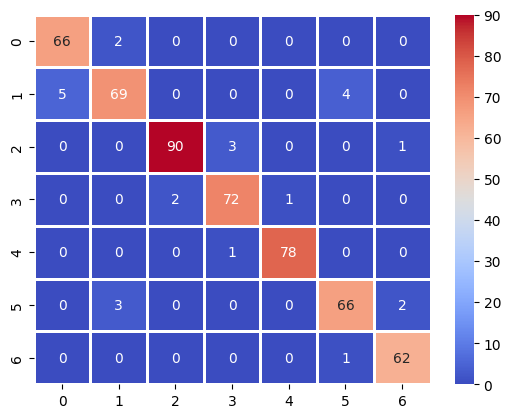

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


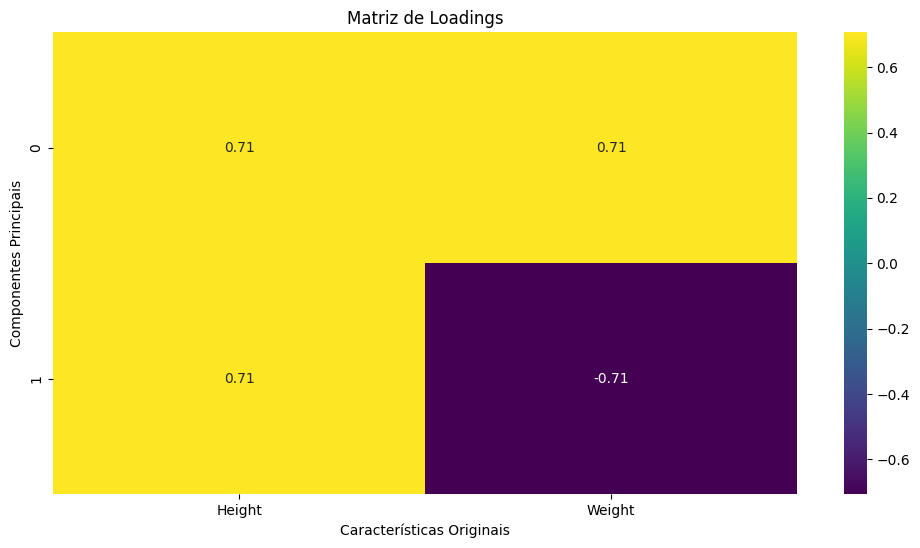

Melhores parametros:  {'SelectKBest__k': 2, 'SelectKBest__score_func': <function mutual_info_classif at 0x0000025D73D1A840>, 'model__algorithm': 'auto', 'model__metric': 'minkowski', 'model__n_neighbors': 2, 'model__weights': 'distance', 'pca__n_components': 2}
Melhor accuracy:  0.9494788962983668
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95        68
         1.0       0.93      0.88      0.91        78
         2.0       0.98      0.96      0.97        94
         3.0       0.95      0.96      0.95        75
         4.0       0.99      0.99      0.99        79
         5.0       0.93      0.93      0.93        71
         6.0       0.95      0.98      0.97        63

    accuracy                           0.95       528
   macro avg       0.95      0.95      0.95       528
weighted avg       0.95      0.95      0.95       528



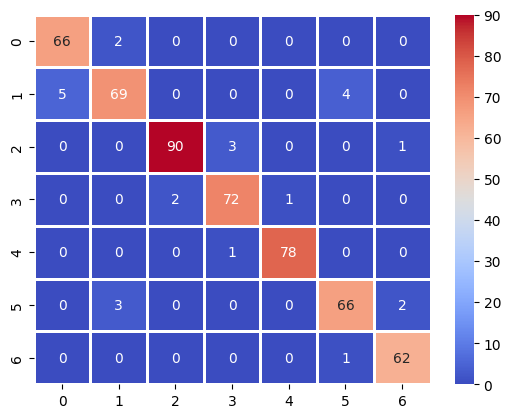

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


,Modelo,DF,Quant_columns,Hyper_Parametros,Acuracia,Recall_Media,Precision_Media,F1_Score_Media
0,KNN,Gender Age Height Weight fami...,2,"{'SelectKBest__k': 2, 'SelectKBest__score_func...",0.952652,0.95,0.95,0.95
1,KNN,Gender Age Height Weight fami...,2,"{'SelectKBest__k': 2, 'SelectKBest__score_func...",0.952652,0.95,0.95,0.95
2,KNN,Gender Age Height Weight fami...,2,"{'SelectKBest__k': 2, 'SelectKBest__score_func...",0.953157,0.95,0.95,0.95
3,KNN,Gender Age Height Weight ...,2,"{'SelectKBest__k': 2, 'SelectKBest__score_func...",0.952652,0.95,0.95,0.95
4,KNN,Gender Age Height Weight ...,2,"{'SelectKBest__k': 2, 'SelectKBest__score_func...",0.952652,0.95,0.95,0.95


In [25]:
df_metricas = pd.DataFrame(columns=['Modelo','DF','Quant_columns','Hyper_Parametros','Acuracia','Recall_Media', 'Precision_Media', 'F1_Score_Media'])

for data_frame in lista_df:
    X_train, X_test, y_train, y_test = train_test_split(data_frame[data_frame.columns[:-1]], data_frame['NObeyesdad'], test_size=0.25,random_state=42,shuffle=True)
    # X_train = np.ascontiguousarray(X_train)
    # X_test = np.ascontiguousarray(X_test)

    pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('SelectKBest', SelectKBest()),
                ('pca', PCA()),
                ('model', KNeighborsClassifier())
                ])
    
    params_pipe = []
    valores_k = range(2, 11)

    for k in valores_k:
        for n in range(2, k + 1):
    
            params_pipe.append({
                'SelectKBest__k': [k],
                'pca__n_components': [n],
                'SelectKBest__score_func':[f_classif,f_oneway,mutual_info_classif],
                'model__algorithm': ['auto','ball_tree'],
                'model__metric':['minkowski','euclidean','hamming','canberra'],
                'model__weights':['uniform','distance'],
                'model__n_neighbors':range(2, 11),
            })

    grid_search = GridSearchCV(estimator = pipe,param_grid=params_pipe,n_jobs=-1,scoring='accuracy')

    grid_search.fit(X_train,y_train)


    pca =grid_search.best_estimator_.named_steps['pca']
    kBest = grid_search.best_estimator_.named_steps['SelectKBest']
    
    components_df = pd.DataFrame(pca.components_, columns=data_frame.columns[kBest.get_support(indices=True).tolist()])

    # Plotagem
    plt.figure(figsize=(12, 6))
    sns.heatmap(components_df, cmap='viridis', annot=True)
    plt.xlabel('Características Originais')
    plt.ylabel('Componentes Principais')
    plt.title('Matriz de Loadings')
    plt.show()

    # Analisando os resultados 
    melhor = grid_search.best_params_
    classificador_grafico = grid_search.best_estimator_ 
    print("Melhores parametros: ",melhor)
    print("Melhor accuracy: ",grid_search.best_score_)
    previsao = classificador_grafico.predict(X_test)
    metricas = classification_report(y_test,previsao)
    print(metricas)
    funcPlotMatriz(y_test, previsao)
    df_metricas = funcMetricas(df_metricas,'KNN',data_frame,len(pca.components_),melhor,y_test,previsao)

display(df_metricas)        

### Algumas Conclusões

O modelo teve uma melhora significativa comparada ao primeiro teste. Ele está apresentando resultados mais que satisfatórios, com a precisão, recall e a acurácia alta.

Outras conclusões que podem ser tiradas são que as colunas selecionadas, que tiveram o melhor desempenho na validação cruzada (Cross-Validation), foram apenas:

- Height
- Weight

Resultado peculiar, pela base ter 16 colunas e o modelo acabar possuindo o melhor resultado com apenas 2 colunas para se basear. Porém, a escolha das colunas faz muito sentido, por conta da relação peso por altura (IMC) descrever bem casos de sobrepeso e desnutrição.

Além disso, ele está com este desempenho com apenas 2 vizinhos como parâmetro, valor meio extremo, que faz sentido para nosso caso, por conta de valores muito baixos de vizinhos serem sensíveis a valores de outliers, e como eu decidi manter os outliers de peso e altura por serem descritivos para este caso de predição, o modelo acabou provando este embasamento com o bom resultado.

Concluindo, o resultado do modelo está muito bom, conseguindo predizer bem todas as 7 classes de resposta.

In [38]:
df_metricas.to_excel('..\comparacao_modelos\DataFrames\df_knn.xlsx')
